# **Framework for Near-Real Time Sensor-Agnostic Water Classification**

A new image is acquired at T1. Landsat (and potentially Sentinel-2) water masks are aggregated from a period of time T0 (T1-3months). Assuming no significant (TBD) change between T0 and T1 in water extent, it should be possible to identify likely change pixels at the boundary of class distributions if sampled across a representative a large enough area (TBD). Omitting such potential change features enables a significant no. training samples at T1 and these may be used to provide water (+ probability) masks at T1 for all clearsky pixels at T1.

Assumptions
- At least 'somewhat' a complete water mask can be obtained by generating a water summary product for T0
- There is a sufficient area of 'clearsky' within the T1 image
- Class transitions are on a sufficiently limited scale that either
    - (1) they do not need to be omitted and model selection will be robust enough to treat them as outliers, or
    - (2) they can be identified as outliers from the major class distributions using skewness/kurtosis
- 

In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
from shapely import wkt

# sac-specific
from sac_utils.createAOI import create_lat_lon

# dc-specific
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
dc = Datacube()

# ml stuff
from sklearn.ensemble import RandomForestClassifier

import utils_dcal.data_cube_utilities.data_access_api as dc_api
api = dc_api.DataAccessApi()

# dask stuff
import dask.array
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Client: scheduler='tcp://10.244.4.62:8786' processes=5 cores=40>

# **(0) Set consistent params**

overall aoi and search criteria to assertain datasets across which to run app

In [3]:
# dc.list_measurements()

In [58]:
viti_levu = "POLYGON((177.47747109686992 -17.376103328077992,178.74364541327617 -17.376103328077992,178.74364541327617 -18.317280451285484,177.47747109686992 -18.317280451285484,177.47747109686992 -17.376103328077992))"
suva = "POLYGON((178.38384316718242 -18.090287234637962,178.49645303046367 -18.090287234637962,178.49645303046367 -18.181641888359497,178.38384316718242 -18.181641888359497,178.38384316718242 -18.090287234637962))"
left = "POLYGON((177.38533176312444 -17.934057815678187,177.52815402874944 -17.934057815678187,177.52815402874944 -18.069888303633736,177.38533176312444 -18.069888303633736,177.38533176312444 -17.934057815678187))"
overall_aoi_wkt = left
overall_aoi_gdf = pd.DataFrame({'geometry':[overall_aoi_wkt]})
overall_aoi_gdf['geometry'] = overall_aoi_gdf['geometry'].apply(wkt.loads)
overall_aoi_gdf['aoi'] = 'aoi'
overall_aoi_gdf = gpd.GeoDataFrame(overall_aoi_gdf, geometry='geometry', crs={"init": "epsg:4326"}) # using {init} important
latitude, longitude = create_lat_lon(overall_aoi_wkt)

product = "s2_esa_sr_granule"
measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

latitude, longitude

((-18.069888303633736, -17.934057815678187),
 (177.38533176312444, 177.52815402874944))

**find datasets** - *note*: lat lon returns all anti-meridian scenes at that longitude, so need additional filtering here

In [59]:
ds = dc.find_datasets(
    product=product,
    lat=latitude,
    lon=longitude,
#     measurements = measurements,
) 
len(ds), # vars(ds[0])

(188,)

get **ds footprints & dates** - *note*: ds.extent.wkt doesn't play nice so use yml metadata as already in 4326 wkt

Date        xmin        xmax       ymin       ymax  \
18  2019-11-18 22:30:09  176.999811  178.037982 -18.176925 -17.181809   
104 2019-11-13 22:30:11  176.999811  178.037982 -18.176925 -17.181809   

                                       id  \
18   b8ac5f35-97c3-53ea-9472-3c10320cd597   
104  8005a132-8199-5de5-a5db-ead45886ab8f   

                                              all_meta  \
18   Dataset <id=b8ac5f35-97c3-53ea-9472-3c10320cd5...   
104  Dataset <id=8005a132-8199-5de5-a5db-ead45886ab...   

                                              geometry   des  
18   POLYGON ((176.9998108864126 -18.17692485527006...  True  
104  POLYGON ((176.9998108864126 -18.17692485527006...  True

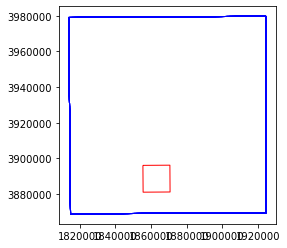

In [73]:
def parsemetaparams(df):
    g = []
    for index, row in df.iterrows():
        g.append(f"Polygon(({row.xmin} {row.ymin}, {row.xmax} {row.ymin}, {row.xmax} {row.ymax}, {row.xmin} {row.ymax}, {row.xmin} {row.ymin}))")
    df['geometry'] = g
    return df
df=pd.DataFrame({
    'Date': [i.metadata.time[0] for i in ds],
    'xmin': [i.metadata.lon[0] for i in ds],
    'xmax': [i.metadata.lon[1] for i in ds],
    'ymin': [i.metadata.lat[0] for i in ds],
    'ymax': [i.metadata.lat[1] for i in ds],
    'id': [i.metadata.id for i in ds],
    'all_meta': [i for i in ds]
})
df = parsemetaparams(df)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=({"init":"epsg:4326"}))
# repro and intersect to omit potemtial am scenes
a = overall_aoi_gdf.to_crs({"init": "epsg:3460"}) # speed intersect up by repro-ing aoi first
gdf['des'] = gdf.to_crs({"init": "epsg:3460"}).geometry.map(lambda x: x.intersects(a.geometry.any())) # repro and test intersect
gdf = gdf[gdf['des']==True] # subset
gdf = gdf.sort_values(by=['Date'], ascending=False)

# check expected footprints etc.
fig, ax = plt.subplots()
gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="b", ax=ax);
overall_aoi_gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="r", ax=ax);
gdf.head(2)

In [74]:
vars(gdf['all_meta'].values[0])

{'type': DatasetType(name='s2_esa_sr_granule', id_=6),
 'metadata_doc': {'id': 'b8ac5f35-97c3-53ea-9472-3c10320cd597',
  'image': {'bands': {'nir': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B08_10m.tif'},
    'red': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B04_10m.tif'},
    'wvp': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_WVP_10m.tif'},
    'blue': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B02_10m.tif'},
    'green': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B03_10m.tif'},
    'swir1': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B11_20m.tif'},
    'swir2': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B12_20m.tif'},
    'water_vapour': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B09_60m.tif'},
    'coastal_aerosol': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B01_60m.tif'},
    'scene_classification': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_SCL_20m.tif'},
    'vegetation_red_edge_1': {'path': 'S2B_MSIL2A_20191118T223009_T60KWF_B05_20m.tif'},
    'vegetation_red_edge_2': {

In [7]:
# work with just most recent image for now
n = 18

In [79]:
# original scene meta for yaml + export later
original_metadata = gdf.iloc[[n]]['all_meta'].values[0]
# format acquistion date of image being classified
T = pd.to_datetime(gdf.iloc[[n]].Date.values[0]).date()
# add a day on to satisfy dc.load time range req
T1 = (str(T), str(pd.to_datetime(T +pd.DateOffset(1)).date()))
# create T0 range of 90 days prior to acquisition
T0 = (str(pd.to_datetime(T + pd.DateOffset(-91)).date()), str(pd.to_datetime(T + pd.DateOffset(-1)).date()))
# lat and lon taken from image metadate
latitude, longitude = create_lat_lon(str(gdf.iloc[[n]].geometry.values[0]))
# hopefully fiji crs avoids major AM issues
output_crs = "EPSG:32760"
resolution = (-10,10)
ref_channel = 'red'

T1_prod = "s2_esa_sr_granule"
T1_measurements = ["green","red","blue","nir","swir1","swir2", "scene_classification"]
T1_vars = ['green','red','blue','nir','swir1','swir2']

print(latitude, longitude)
print(T1, T0)
print(ref_channel)

(-18.17692485527006, -17.1818090056905) (176.9998108864126, 178.0379818617233)
('2019-04-17', '2019-04-18') ('2019-01-16', '2019-04-16')
red


# **(1) create T0 water mask (T1-3months)**

**load T0 water masks**

In [9]:
product = 'ls8_water_classification'
measurements = ['water']

water_dataset = dc.load(
    product=product,
    time=T0, # quarter prior to T1 
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
water_dataset

<xarray.Dataset>
Dimensions:  (time: 17, x: 11042, y: 11041)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-20T22:12:37 ... 2019-04-12T21:59:55
  * y        (y) float64 8.1e+06 8.1e+06 8.1e+06 ... 7.99e+06 7.99e+06 7.99e+06
  * x        (x) float64 5e+05 5e+05 5e+05 ... 6.104e+05 6.104e+05 6.104e+05
Data variables:
    water    (time, y, x) int16 dask.array<shape=(17, 11041, 11042), chunksize=(1, 1000, 1000)>
Attributes:
    crs:      EPSG:32760

fully **remove nodata** pixels (can't just use ==-9999 due to potential nn averaging within dc.load() at res <native

In [10]:
# Identify pixels with valid data
good_quality = (
    (water_dataset.water >= 0) # no data
)
# Apply mask
water_dataset = water_dataset.where(good_quality)

**define dask computation** of water summary product

In [11]:
mean_dataset = water_dataset.water.mean(dim='time')

**apply computation** to water masks dataset & plot

In [12]:
%%time
mean_dataset = mean_dataset.compute()

CPU times: user 5.4 s, sys: 2.89 s, total: 8.29 s
Wall time: 1min 50s


In [13]:
del water_dataset
client.restart()

<Client: scheduler='tcp://10.244.4.62:8786' processes=5 cores=40>

In [14]:
# %%time
# fig, ax = plt.subplots(figsize=(50,50))
# ax.imshow(mean_dataset)
# # mean_dataset.plot(ax=ax)

**create binary water mask** based on summary product (based off likelihood of being persistent water bodies)

In [15]:
%%time
waterpres_prob = 0.5
T0_nd_water = np.isnan(mean_dataset)
T0_water = mean_dataset.where((mean_dataset < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
T0_water = T0_water.where((T0_water >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water 

# fig, ax = plt.subplots(figsize=(50,50))
# ax.imshow(T0_water)
# # T0_water.plot(ax=ax)

CPU times: user 1.64 s, sys: 1.43 s, total: 3.07 s
Wall time: 3.07 s


# **(2) load T1 image**

**load** l8

In [16]:
product = T1_prod
measurements = T1_measurements

landsat_dataset = dc.load(
    product=product,
    time=T1, # we know a nice single image is here
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
#     group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
landsat_dataset

<xarray.Dataset>
Dimensions:               (time: 1, x: 11042, y: 11041)
Coordinates:
  * time                  (time) datetime64[ns] 2019-04-17T22:30:11
  * y                     (y) float64 8.1e+06 8.1e+06 ... 7.99e+06 7.99e+06
  * x                     (x) float64 5e+05 5e+05 5e+05 ... 6.104e+05 6.104e+05
Data variables:
    green                 (time, y, x) uint16 dask.array<shape=(1, 11041, 11042), chunksize=(1, 1000, 1000)>
    red                   (time, y, x) uint16 dask.array<shape=(1, 11041, 11042), chunksize=(1, 1000, 1000)>
    blue                  (time, y, x) uint16 dask.array<shape=(1, 11041, 11042), chunksize=(1, 1000, 1000)>
    nir                   (time, y, x) uint16 dask.array<shape=(1, 11041, 11042), chunksize=(1, 1000, 1000)>
    swir1                 (time, y, x) uint16 dask.array<shape=(1, 11041, 11042), chunksize=(1, 1000, 1000)>
    swir2                 (time, y, x) uint16 dask.array<shape=(1, 11041, 11042), chunksize=(1, 1000, 1000)>
    scene_classifica

apply **clearsky mask** to image

In [17]:
# Identify pixels with valid data
# good_quality = (
#     (landsat_dataset.pixel_qa == 322)  | # clear
#     (landsat_dataset.pixel_qa == 386)  |
#     (landsat_dataset.pixel_qa == 834)  |
#     (landsat_dataset.pixel_qa == 898)  |
#     (landsat_dataset.pixel_qa == 1346) |
#     (landsat_dataset.pixel_qa == 324)  | # water
#     (landsat_dataset.pixel_qa == 388)  |
#     (landsat_dataset.pixel_qa == 836)  |
#     (landsat_dataset.pixel_qa == 900)  |
#     (landsat_dataset.pixel_qa == 1348)
# )
good_quality = (
    (landsat_dataset.scene_classification != 0) & # mask out NO_DATA
    (landsat_dataset.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
    (landsat_dataset.scene_classification != 3) & # mask out CLOUD_SHADOWS
    (landsat_dataset.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
    (landsat_dataset.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
    (landsat_dataset.scene_classification != 10)  # mask out THIN_CIRRUS
)

# Apply mask
landsat_dataset = landsat_dataset.where(good_quality)

**isolate image**

In [18]:
T1_img = landsat_dataset.isel(time = 0)

In [19]:
# %%time
# fig, ax = plt.subplots(figsize=(50,50))
# # T1_img[ref_channel].plot(ax=ax)
# ax.imshow(T1_img[ref_channel])

# **(#) Load T1 Water Mask** for validation

**load T1 water mask** for validation

In [20]:
# product = 'ls8_water_classification'
# measurements = ['water']

# water_dataset = dc.load(
#     product=product,
#     time=T1, 
#     lat=latitude,
#     lon=longitude,
#     output_crs=output_crs,
#     resolution=resolution,
#     measurements = measurements,
#     group_by='solar_day',
#     dask_chunks={
#         #'time': 1,
#         'x': 1000,
#         'y': 1000,
#     }
# )
# water_dataset

fully remove nodata pixels (can't just use ==-9999 due to potential nn averaging within dc.load() at res <native

In [21]:
# # Identify pixels with valid data
# good_quality = (
#     (water_dataset.water >= 0) # no data
# )
# # Apply mask
# water_dataset = water_dataset.where(good_quality)

# T1_water = water_dataset.isel(time = 0).water
# fig, ax = plt.subplots(figsize=(50,50))
# # T1_img[ref_channel].plot(ax=ax)
# ax.imshow(T1_water)

# **(3) Data fusion prep**

Training (class exploration + training):
- create outside merge nodata mask
- apply outside merge nodata mask
- numpify xr dataset(arrays)
- flatten
- remove nodata (can't be sparse for training)
- transpose

Inference
- [create outside merge, if validating]
- [apply no data mask]
- numpify
- flatten
- [1] remove nodata for accurate validation
- [2] replace nodata to maintain positioning

## (3A) Training prep

**create outside merge of nodata** - T1 img + T0 water mask

In [22]:
%%time
# create mask
T0_nd_img = np.isnan(T1_img)[ref_channel]
T0_nd = T0_nd_water.where((T0_nd_img == False),True)

# apply mask
Ytrain = T0_water.where((T0_nd == False))
Xtrain = T1_img.where((T0_nd == False))

# fig, ax = plt.subplots(figsize=(50,50))
# ax.imshow(Ytrain)
# fig, ax = plt.subplots(figsize=(50,50))
# # ax.imshow(Xtrain.where(Xtrain[ref_channel]>0)[ref_channel])
# ax.imshow(Xtrain[ref_channel])

CPU times: user 4.45 s, sys: 3.61 ms, total: 4.45 s
Wall time: 4.44 s


**numpify** T1 image data

In [23]:
%%time
des_vars = T1_vars

lenx, leny = np.shape(Xtrain[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(Xtrain.data_vars),1), Xtrain.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(Xtrain[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

0 green
1 red
2 blue
3 nir
4 swir1
5 swir2
6 scene_classification
CPU times: user 29.3 s, sys: 23.2 s, total: 52.5 s
Wall time: 3min 39s


**re-shape**/flatten T1 data + T0 labels

In [24]:
Xtrain = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
Ytrain = Ytrain.values.flatten()

Xtrain.shape, Ytrain.shape

((6, 121914722), (121914722,))

**remove coincident nd from arrays** variables

In [25]:
Xtrain = np.array([i[~np.isnan(i)] for i in Xtrain])
Ytrain = Ytrain[~np.isnan(Ytrain)]

Xtrain.shape, Ytrain.shape

((6, 50016023), (50016023,))

**transpose** variables

In [26]:
Xtrain = Xtrain.transpose()  # transpose so that bands are read as features

Xtrain.shape, Ytrain.shape

((50016023, 6), (50016023,))

## (3B) Inference Validation Prep

**create outside merge of nodata** - T1 img + T1 water mask

In [27]:
# # create
# T1_nd_water = np.isnan(T1_water)
# T1_img_nd = np.isnan(T1_img)[ref_channel]
# T1_merge_nd = T1_nd_water.where((T1_img_nd == False),True)
# # apply
# Yval = T1_water.where((T1_merge_nd == False))
# Xval = T1_img.where((T1_merge_nd == False))

# fig, ax = plt.subplots(figsize=(50,50))
# # Yval.plot(ax=ax)
# ax.imshow(Yval)
# fig, ax = plt.subplots(figsize=(50,50))
# # Xval.where(Xval[ref_channel]>0)[ref_channel].plot(ax=ax)
# ax.imshow(Xval[ref_channel])

**numpify** T1 image data - within merge

In [28]:
# des_vars = T1_vars

# lenx, leny = np.shape(Xval[ref_channel]) # dims of each raster
# dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

# for i, m in zip(np.arange(0,len(Xval.data_vars),1), Xval.variables): # loop through bands in xr
#     print(i, m)
#     if m in des_vars: # only want relevant channels
#         vals = np.array(Xval[m].values) # extract only the reflectance values
#         dsvals[i,:,:] = vals # append to 'master' ND array
# # plt.imshow(dsvals[0,:,:])

**re-shape**/flatten T1 data + T1 labels

In [29]:
# Xval = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
# Yval = Yval.values.flatten()

# Xval.shape, Yval.shape

**remove coincident nd from arrays** variables

In [30]:
# Xval = np.array([i[~np.isnan(i)] for i in Xval])
# Yval = Yval[~np.isnan(Yval)]

# Xval.shape, Yval.shape

**transpose** variables

In [31]:
# Xval = Xval.transpose()  # transpose so that bands are read as features

# Xval.shape, Yval.shape

## (3C) Inference Implementation Prep

**numpify** T1 image data - within merge

In [32]:
%%time
des_vars = ['green','red','blue','nir','swir1','swir2']

lenx, leny = np.shape(T1_img[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(T1_img.data_vars),1), T1_img.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(T1_img[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

0 green
1 red
2 blue
3 nir
4 swir1
5 swir2
6 scene_classification
CPU times: user 21.8 s, sys: 22.9 s, total: 44.7 s
Wall time: 2min 46s


**re-shape**/flatten T1 data + T1 labels

In [33]:
Ximp = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
dsvals = None

Ximp.shape

(6, 121914722)

**replace coincident nd from arrays** variables

**transpose** variables

In [34]:
Ximp = Ximp.transpose()  # transpose so that bands are read as features

Ximp.shape

(121914722, 6)

In [35]:
foundnans = np.isnan(Ximp)
Ximp[foundnans] = 0

# **(4) Class Exploration**

**separate class vars**

In [35]:
X, Y = Xtrain, Ytrain
X, X.shape, Y,Y.shape

x_t = [X[:, i][Y==1] for i in range(X.shape[1])]
x_f = [X[:, i][Y==0] for i in range(X.shape[1])]
# x_t, x_f

**plot native class distributions in available vars**

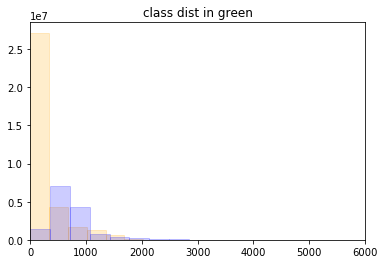

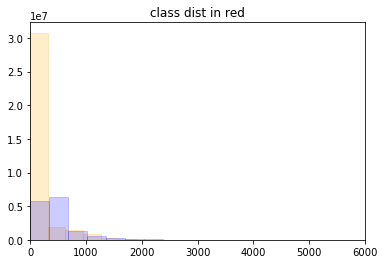

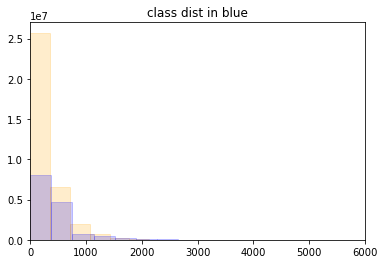

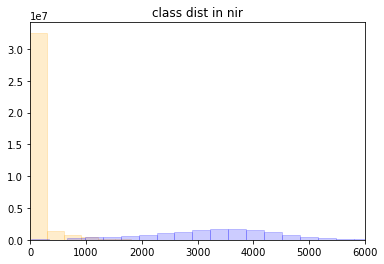

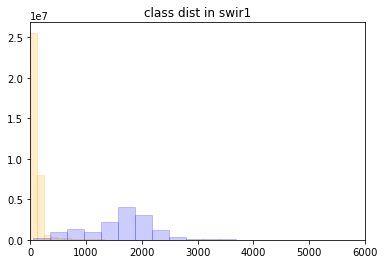

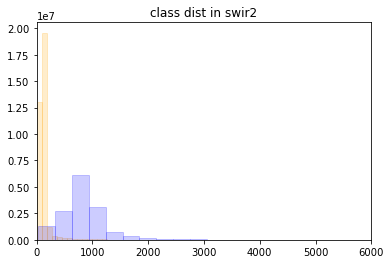

In [36]:
n_bins = 50
i = 0
for t, f in zip(x_t, x_f):
    fig, ax = plt.subplots()
    ax.set_title(f"class dist in {[j for j in T1_img][i]}")
    ax.hist(t, bins=n_bins, color='orange', edgecolor='orange',alpha=0.2);
    ax.hist(f, bins=n_bins, color='blue', edgecolor='blue',alpha=0.2)
    ax.set_xlim(0, 6000)
    i+=1

In [37]:
# from sklearn.decomposition import PCA

In [38]:
# pca = PCA(n_components=2)

In [39]:
# %%time
# pca.fit(x_t)

In [40]:
# print(pca.singular_values_)
# print(pca.explained_variance_ratio_)

In [41]:
# %%time
# x_t_tpca = pca.fit_transform(np.transpose(x_t))
# x_f_tpca = pca.transform(np.transpose(x_f))

# x_f_fpca = pca.fit_transform(np.transpose(x_f))
# x_t_fpca = pca.transform(np.transpose(x_t))

In [42]:
# for i, p in enumerate(['Principle Component 1','Principle Component 2']):
#     fig, ax = plt.subplots()
#     ax.set_title(f'Water Class PCA Distributions: {p}')
#     ax.hist(x_t_tpca[:,i], bins=n_bins, color='orange', edgecolor='orange',alpha=0.2);
#     ax.hist(x_f_tpca[:,i], bins=n_bins, color='blue', edgecolor='blue',alpha=0.2);

# for i, p in enumerate(['Principle Component 1','Principle Component 2']):
#     fig, ax = plt.subplots()
#     ax.set_title(f'non-Water Class PCA Distributions: {p}')
#     ax.hist(x_f_fpca[:,i], bins=n_bins, color='orange', edgecolor='orange',alpha=0.2);
#     ax.hist(x_t_fpca[:,i], bins=n_bins, color='blue', edgecolor='blue',alpha=0.2);

TBD

# **(5) Training of T1 using T0 labels**

define **model params**

In [38]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=10, 
                               bootstrap = True,
                               max_features = 'sqrt',
                               max_depth=2,
                               n_jobs=2,
                               verbose=2
                              )

**fit model**

In [39]:
%%time
rf = model.fit(Xtrain, Ytrain)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
CPU times: user 12min 21s, sys: 32 s, total: 12min 54s
Wall time: 6min 38s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  6.5min finished


**score model on training set** - should be replaced with cross-validation

In [40]:
rf_score = rf.score(Xtrain, Ytrain)
rf_score

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   18.7s finished


0.9776587994611247

In [42]:
%%time
rf = model.fit(Xtrain, Ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
CPU times: user 12min 6s, sys: 30.1 s, total: 12min 37s
Wall time: 12min 36s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.4min finished


**score model on training set** - should be replaced with cross-validation

In [1]:
rf_score = rf.score(Xtrain, Ytrain)
rf_score

NameError: name 'rf' is not defined

extract & plot **variable importances**

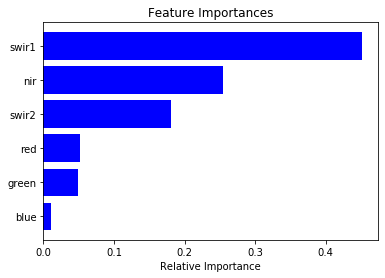

In [41]:
importances = rf.feature_importances_

indices = np.argsort(importances)
features = [i for i in T1_img]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

extract and **plot decision tree** - TBC

# **(6) Validate against full T1 image & mask**

In [42]:
# rf_val_res = rf.predict(Xval)
# rf_val_probs = rf.predict_proba(Xval)[:, 1]

In [43]:
# rf_val_score = rf.score(Xval, Yval)
# f"{round(rf_val_score, 4)*100} %"

# **(6) Implement on full T1 image**

In [118]:
predicted = rf.predict(Ximp)
predicted = np.array(predicted)
probability = rf.predict_proba(Ximp)[:, 1]
probability = np.array(probability)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   44.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   43.6s finished


make dataset again

In [122]:
probability = probability*100
probability[foundnans[:,0]] = -9999
probability = probability.astype(np.int16)
probability = np.reshape(probability, [lenx, leny])

predicted = predicted
predicted[foundnans[:,0]] = -9999
predicted = predicted.astype(np.int16)
predicted = np.reshape(predicted, [lenx, leny])

In [123]:
# predicted[foundnans[:,0]] = np.nan
# probability[foundnans[:,0]] = np.nan

In [124]:
# predicted = np.reshape(predicted, [lenx, leny])
# probability = np.reshape(probability, [lenx, leny])

In [125]:
ds = landsat_dataset
ds['water_mask'] = (('y','x'), predicted)
ds['water_prob'] = (('y','x'), probability)

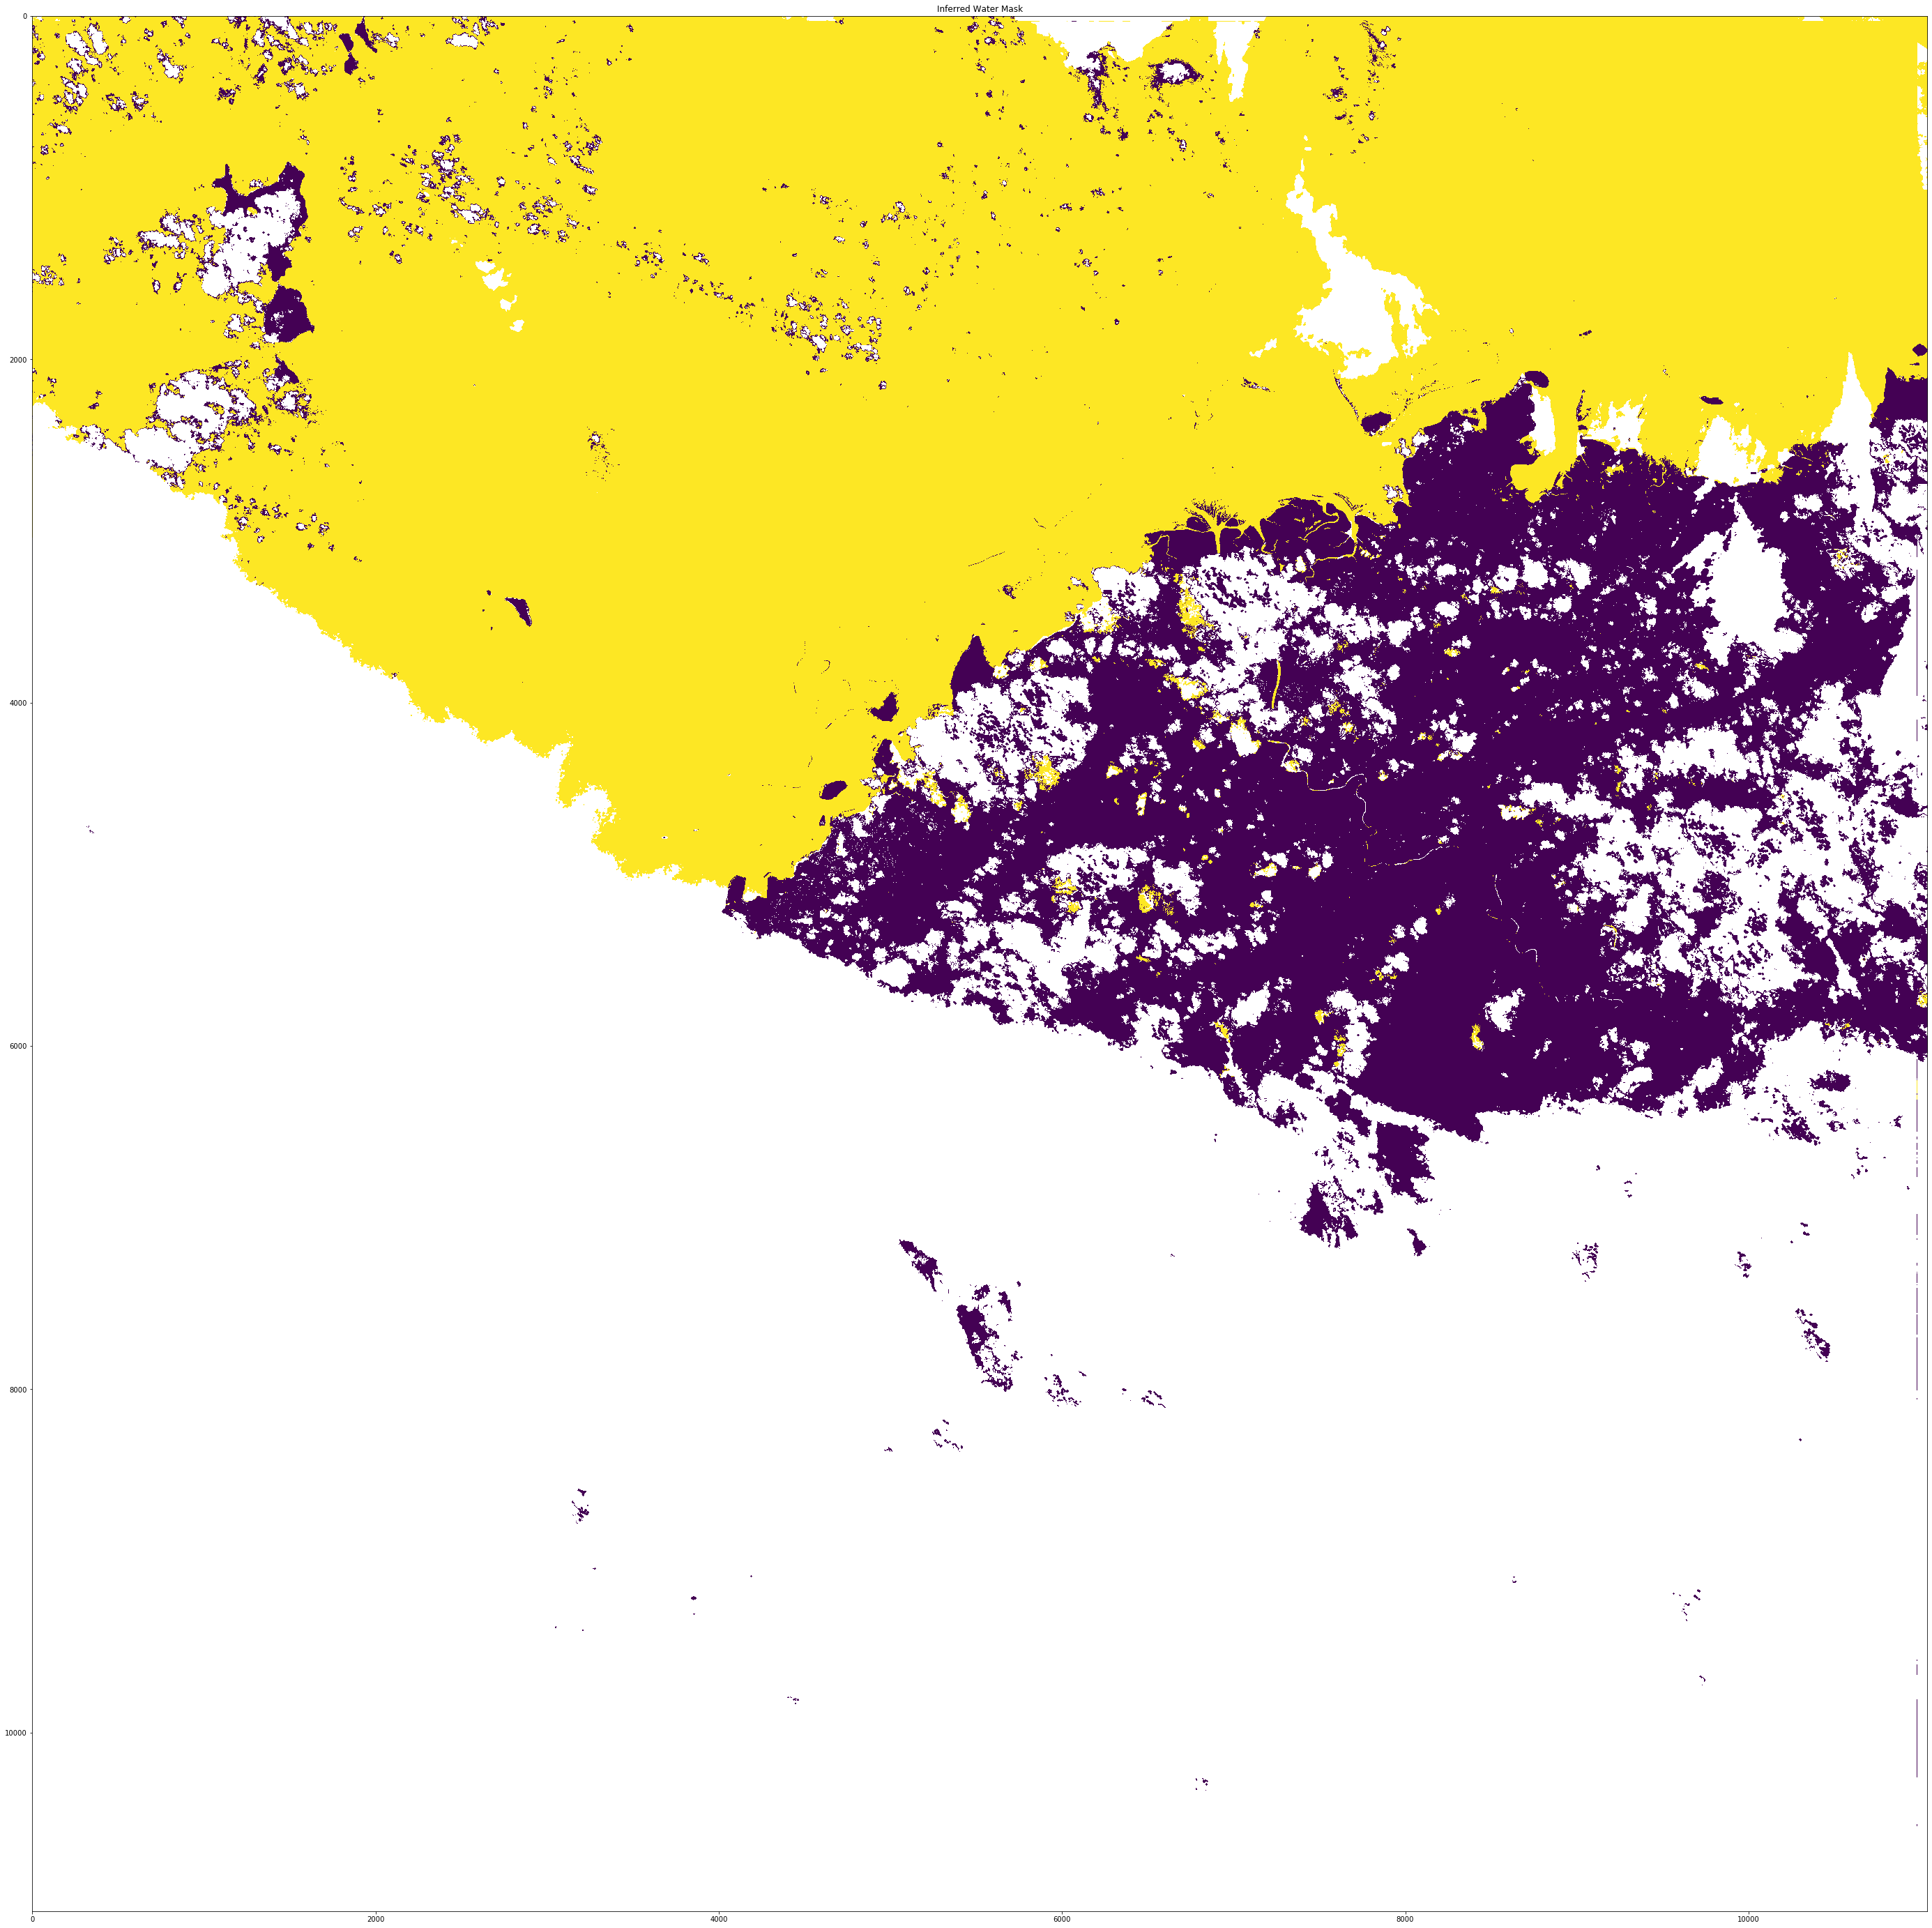

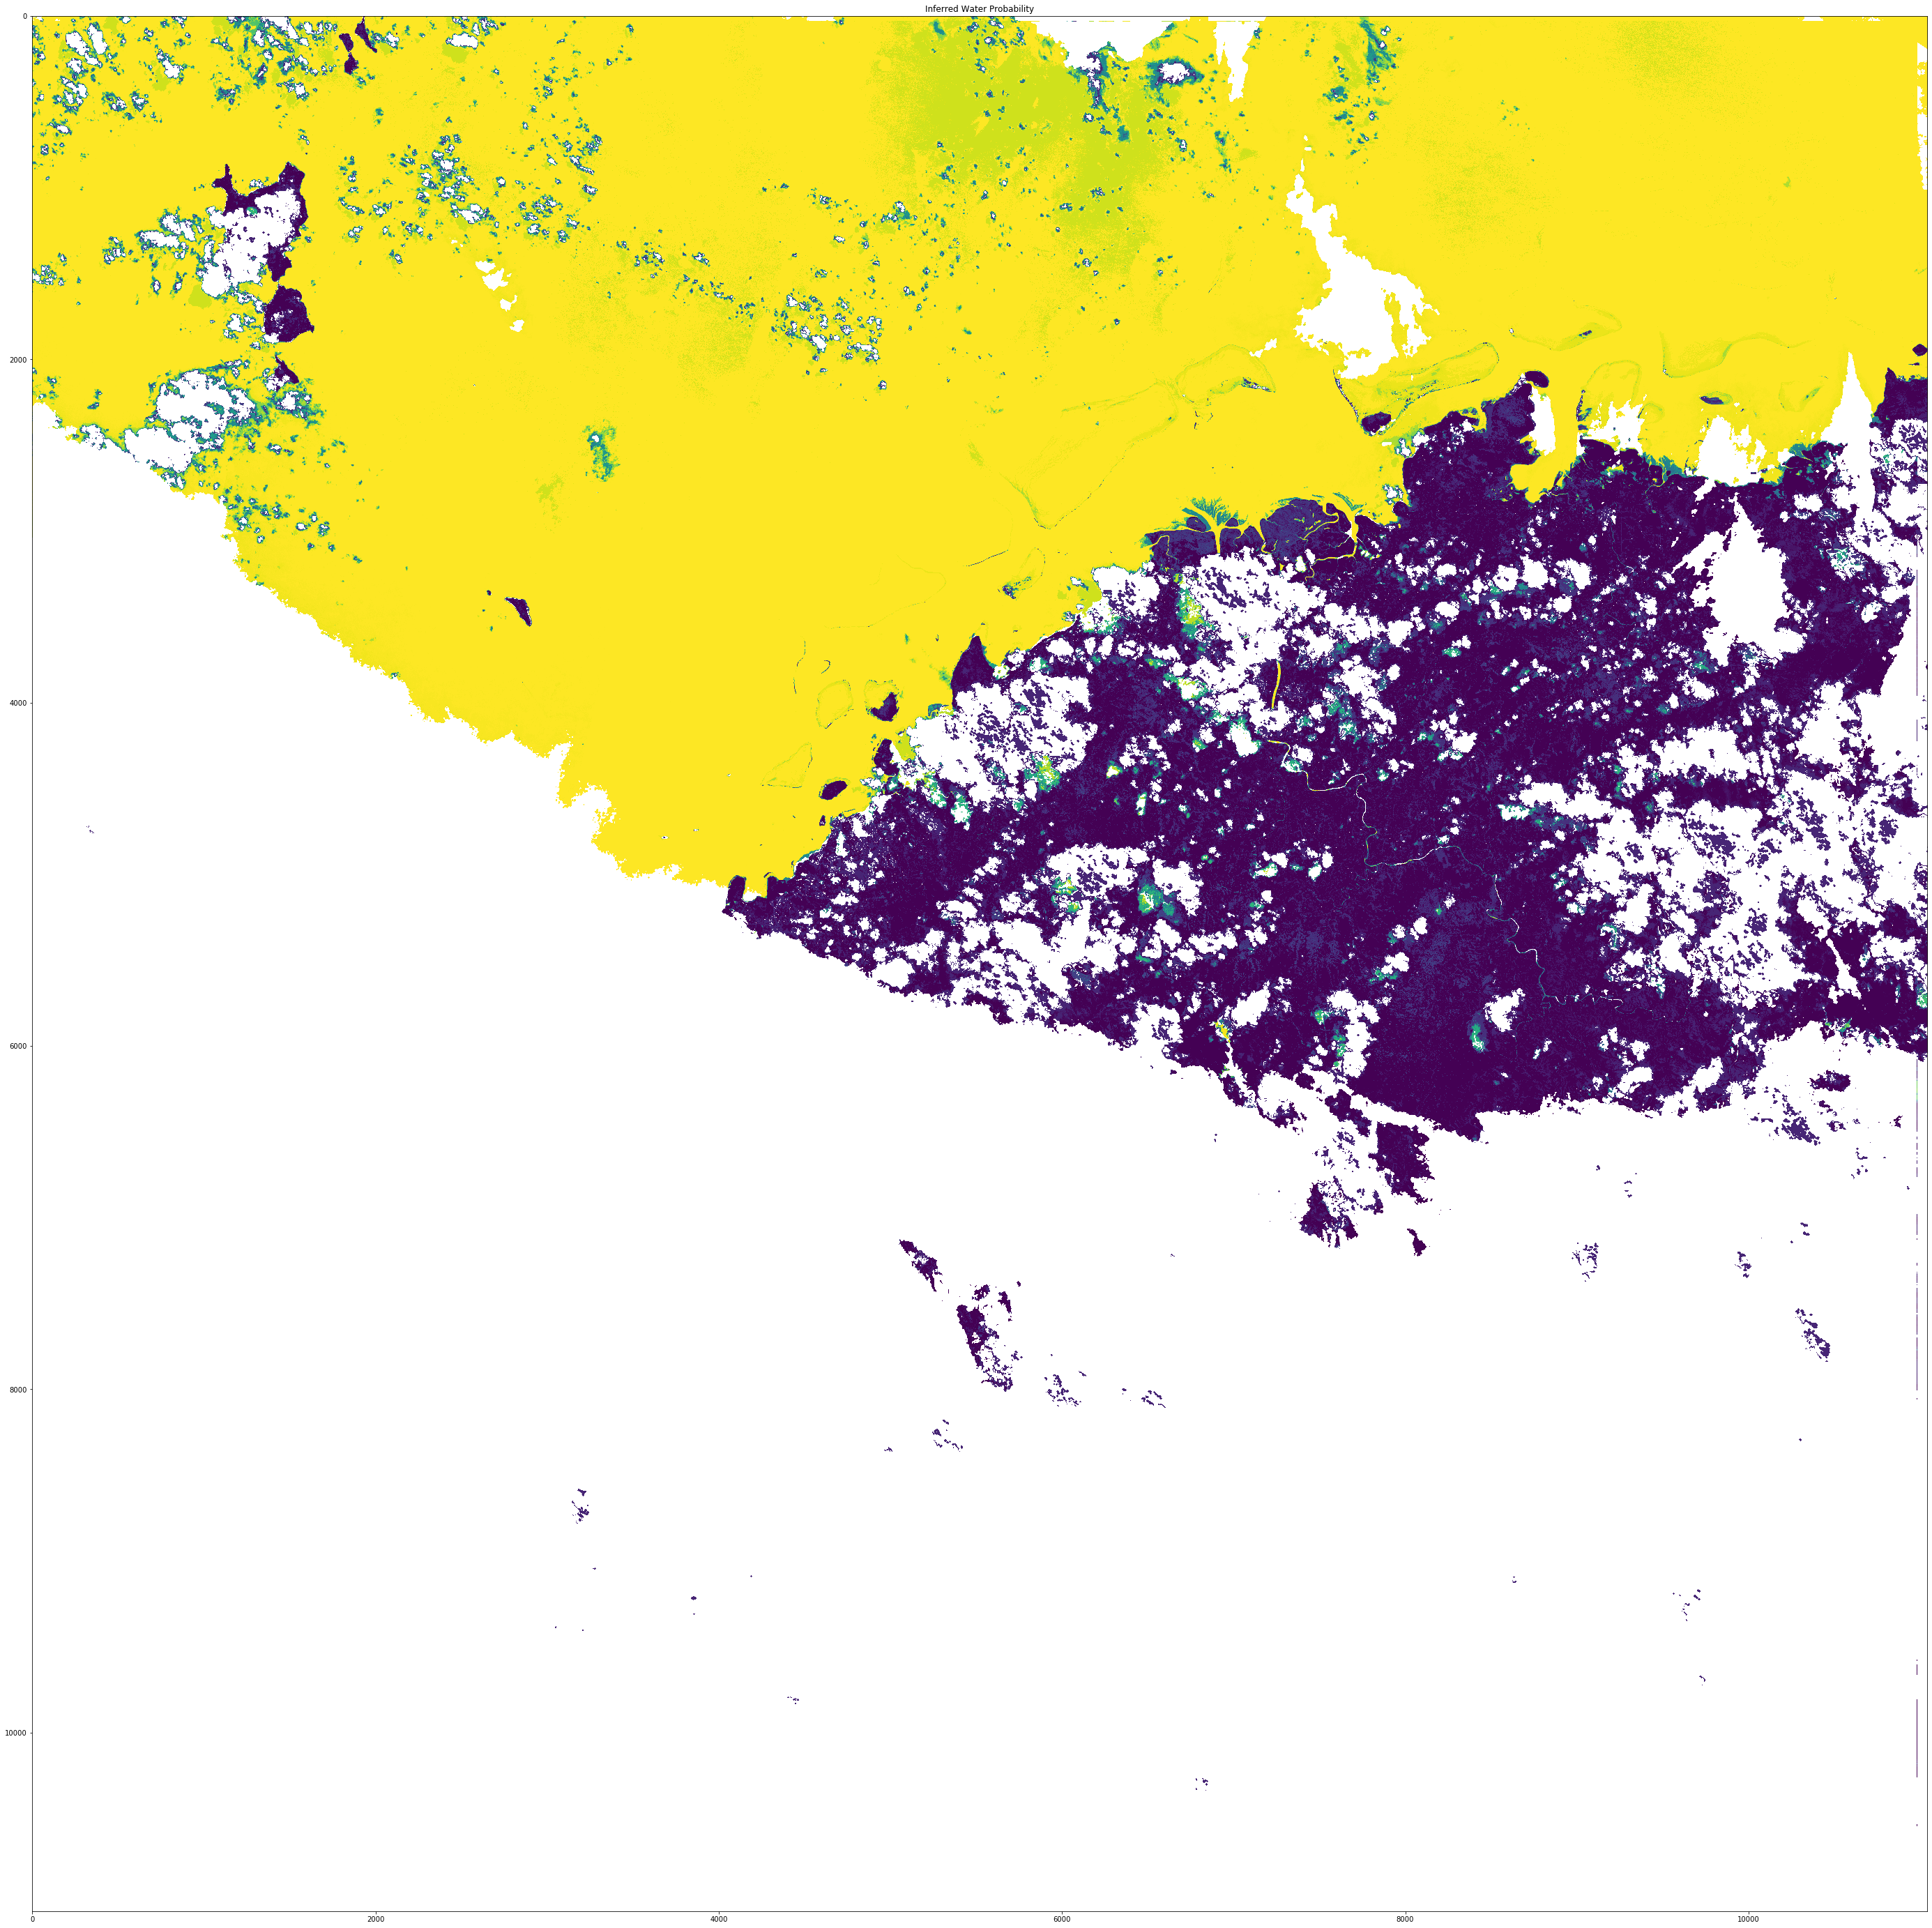

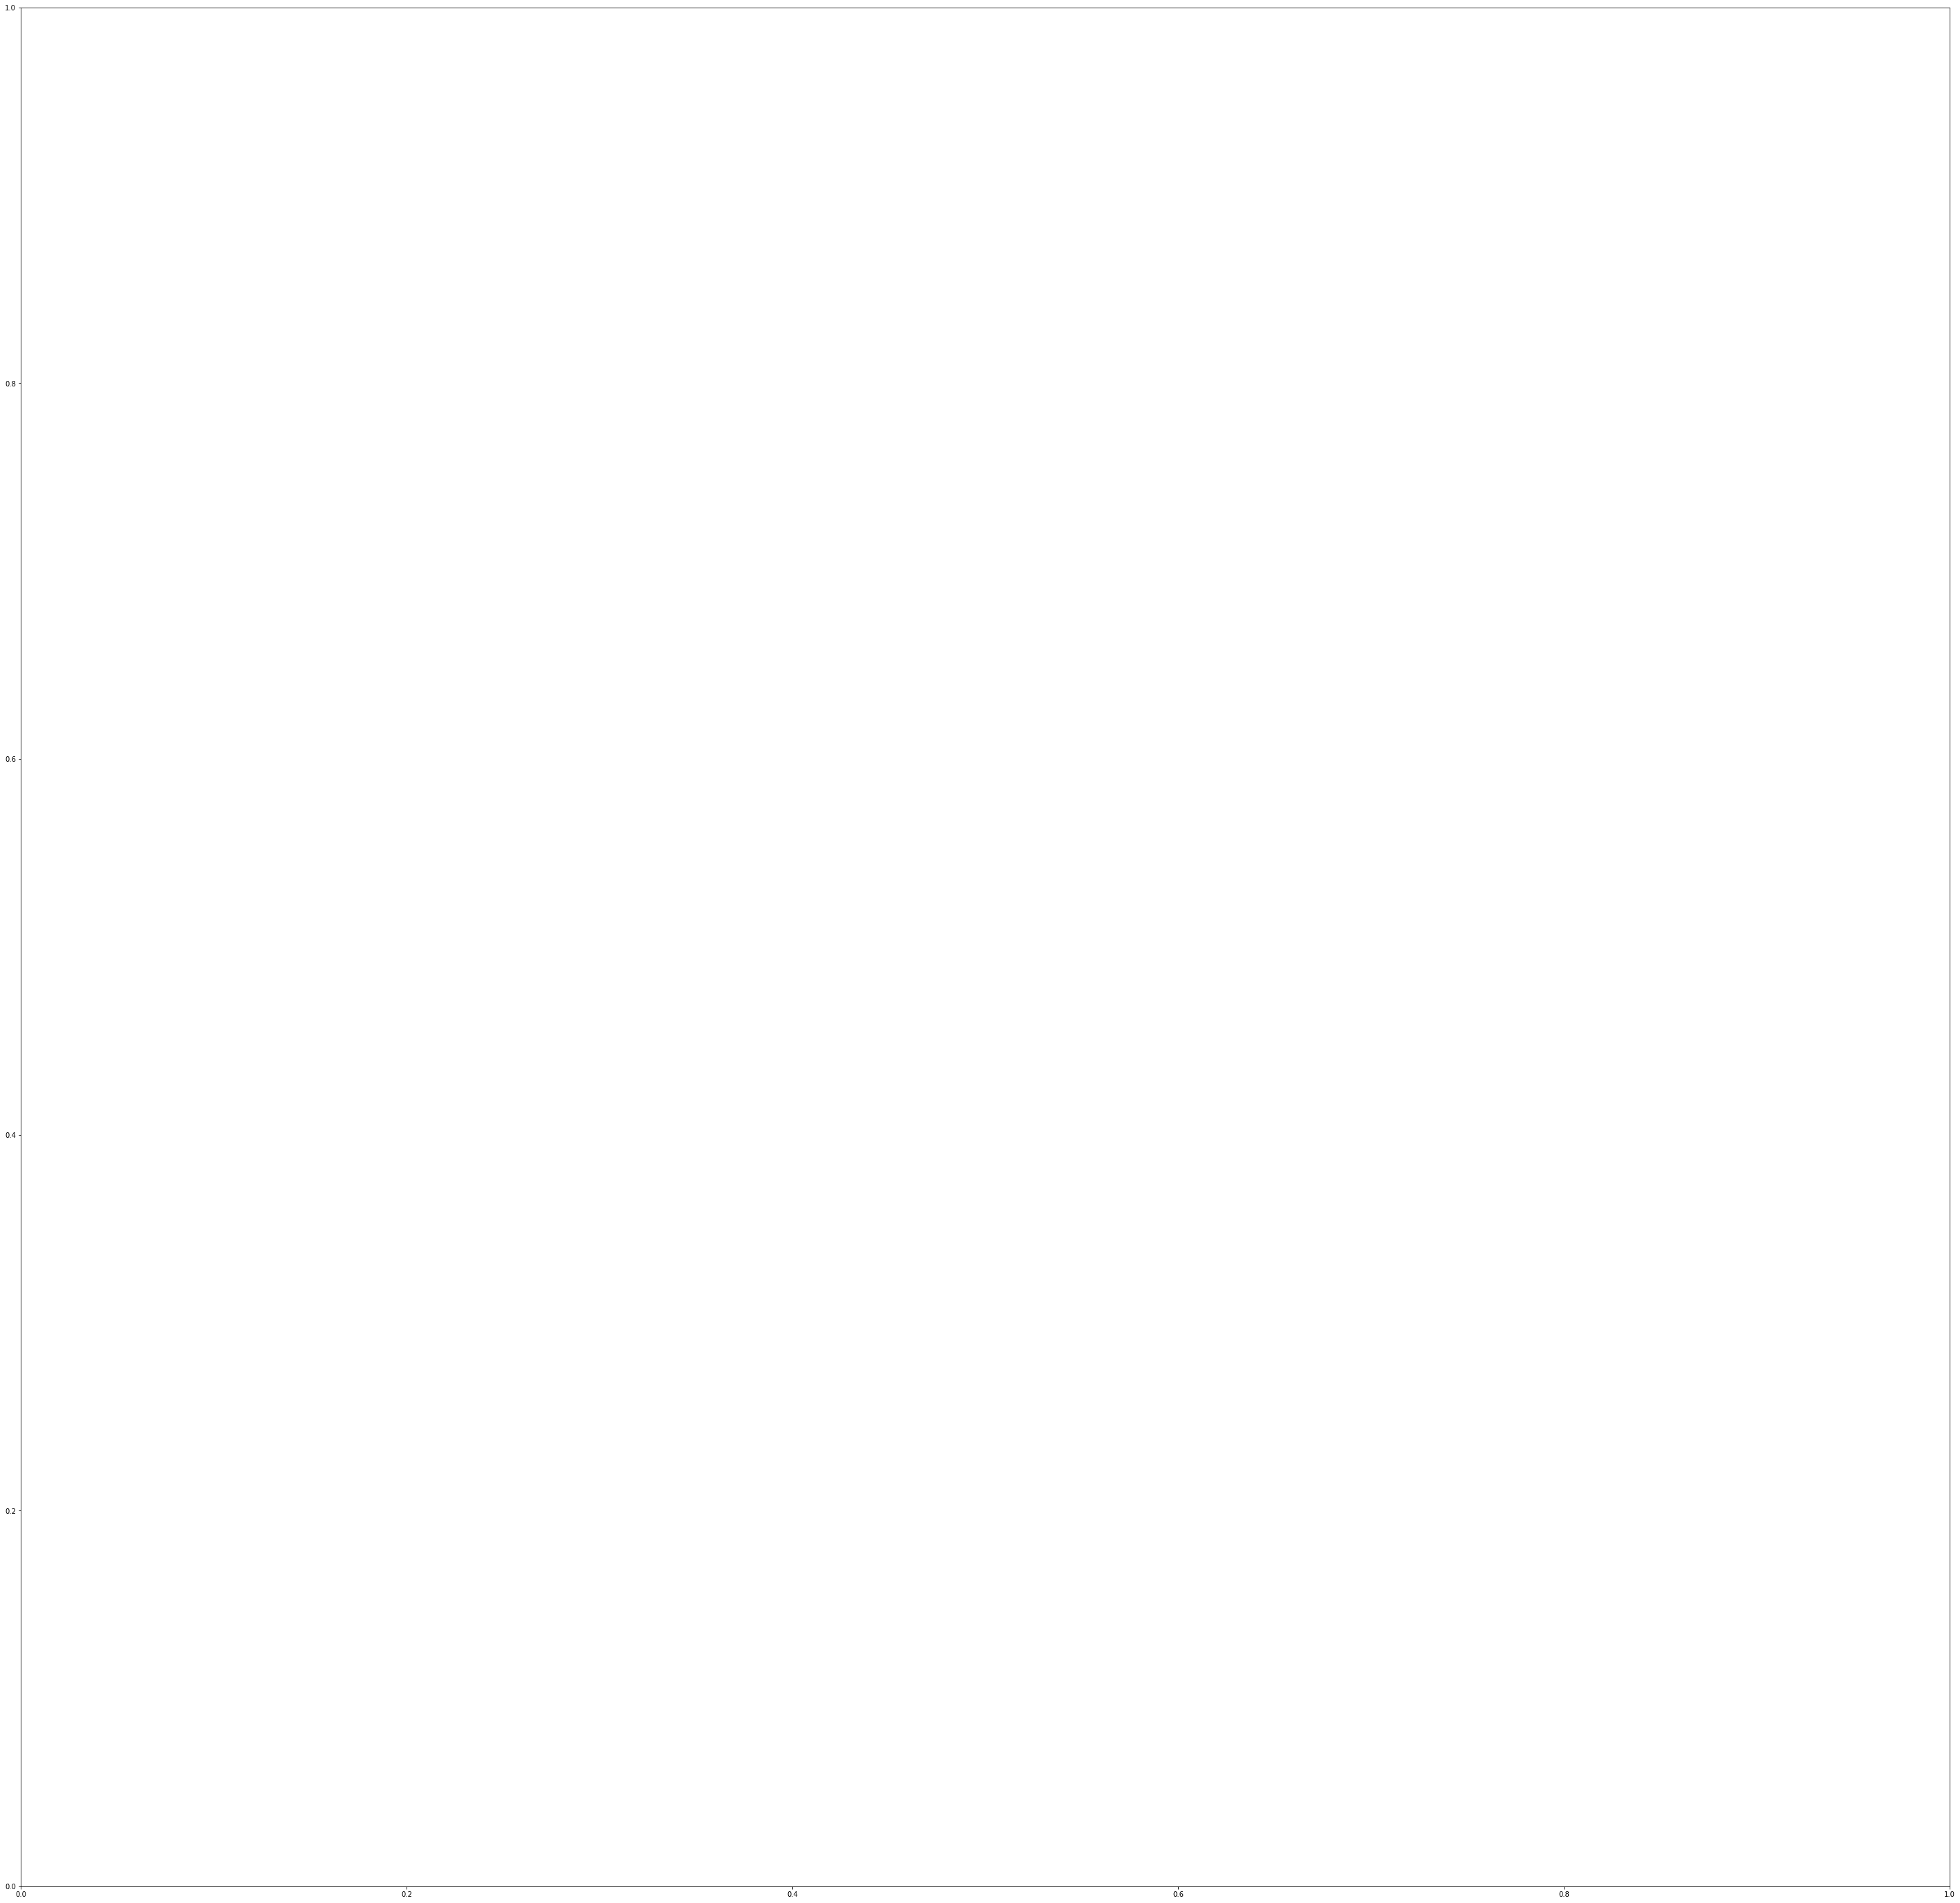

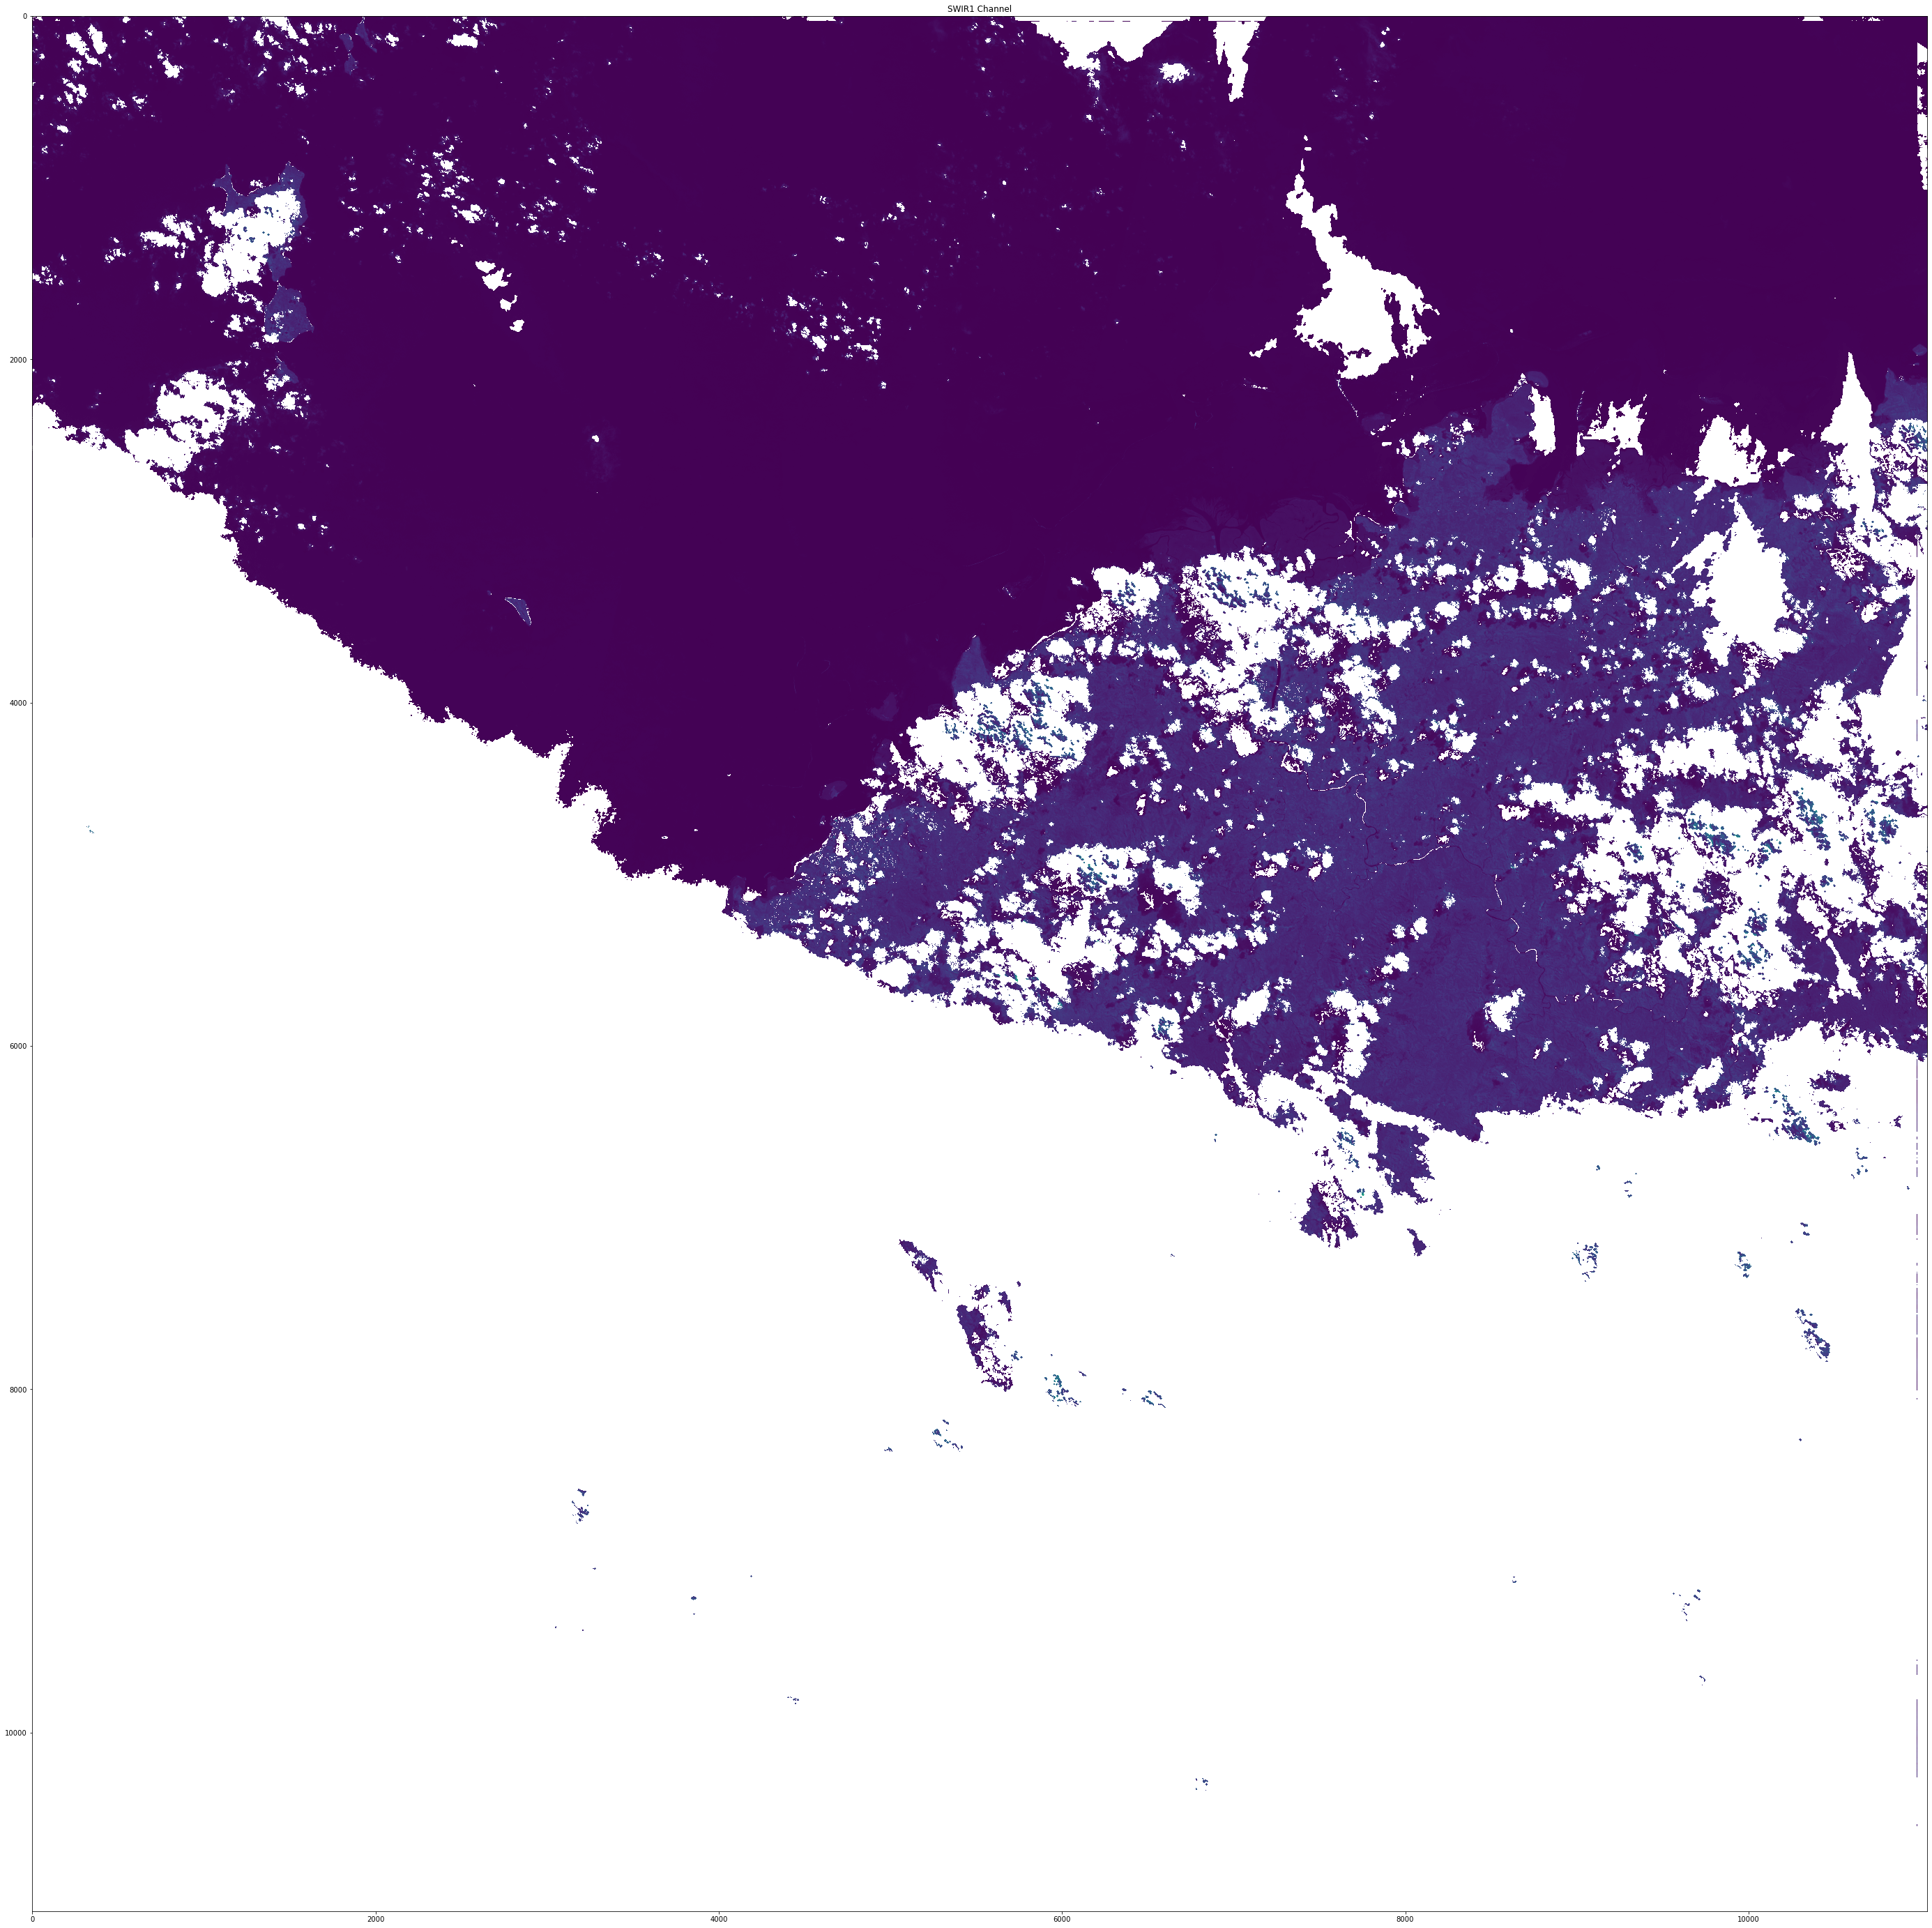

In [48]:
fig, ax = plt.subplots(figsize=(50,50))
# ds.water_mask.plot(ax=ax);
ax.imshow(ds.water_mask.where(ds.water_mask>=0))
ax.set_title('Inferred Water Mask')
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(ds.water_prob.where(ds.water_prob>=0))
# ds.water_prob.plot(ax=ax);
ax.set_title('Inferred Water Probability')
fig, ax = plt.subplots(figsize=(50,50))
# T1_water.plot(ax=ax);
# ax.imshow(T1_water)
# ax.set_title('Wofs Water Mask')
fig, ax = plt.subplots(figsize=(50,50))
# ds.swir1.where(ds.red>0).plot(ax=ax);
ax.imshow(T1_img.swir1)
ax.set_title('SWIR1 Channel');

# **(7) Export(s)**

In [126]:
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_geotiff
import os

In [134]:
# export stuff
inter_dir = '/home/jovyan/ml_outputs/water_products/'
scene_nm = original_metadata.uris[0].split('/')[-2] # assumes scenename as dir of indexed metadata 
local_prodir = inter_dir + scene_nm + '/'
os.makedirs(local_prodir, exist_ok=True)
out_mask_prod = local_prodir + scene_nm + '_watermask.tif'
out_prob_prod = local_prodir + scene_nm + '_waterprob.tif'

scene_nm, local_prodir, out_mask_prod, out_prob_prod

('S2A_MSIL2A_20190417T223011_T60KWF',
 '/home/jovyan/ml_outputs/water_products/S2A_MSIL2A_20190417T223011_T60KWF/',
 '/home/jovyan/ml_outputs/water_products/S2A_MSIL2A_20190417T223011_T60KWF/S2A_MSIL2A_20190417T223011_T60KWF_watermask.tif',
 '/home/jovyan/ml_outputs/water_products/S2A_MSIL2A_20190417T223011_T60KWF/S2A_MSIL2A_20190417T223011_T60KWF_waterprob.tif')

In [135]:
%%time
export_xarray_to_geotiff(ds, out_mask_prod, bands=['water_mask'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)

CPU times: user 527 ms, sys: 637 ms, total: 1.16 s
Wall time: 1.16 s


In [136]:
%%time
export_xarray_to_geotiff(ds, out_prob_prod, bands=['water_prob'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)

CPU times: user 481 ms, sys: 726 ms, total: 1.21 s
Wall time: 1.21 s


In [133]:
!ls -lh /home/shared/ml_outputs/water_products/S2A_MSIL2A_20190417T223011_T60KWF/*

-rw-r--r-- 1 jovyan 2000 233M Feb 13 11:34 /home/shared/ml_outputs/water_products/S2A_MSIL2A_20190417T223011_T60KWF/S2A_MSIL2A_20190417T223011_T60KWF_watermask.tif
-rw-r--r-- 1 jovyan 2000 233M Feb 13 11:35 /home/shared/ml_outputs/water_products/S2A_MSIL2A_20190417T223011_T60KWF/S2A_MSIL2A_20190417T223011_T60KWF_waterprob.tif


In [107]:
# yaml stuff
o_dtme = pd.to_datetime(original_metadata.center_time)

(Timestamp('2019-04-17 22:30:11'), 'S2A_MSIL2A_20190417T223011_T60KWF')

In [80]:
vars(original_metadata)

{'type': DatasetType(name='s2_esa_sr_granule', id_=6),
 'metadata_doc': {'id': '14366e25-9fce-57e7-8c2e-da6da970b9cf',
  'image': {'bands': {'nir': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B08_10m.tif'},
    'red': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B04_10m.tif'},
    'wvp': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_WVP_10m.tif'},
    'blue': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B02_10m.tif'},
    'green': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B03_10m.tif'},
    'swir1': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B11_20m.tif'},
    'swir2': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B12_20m.tif'},
    'water_vapour': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B09_60m.tif'},
    'coastal_aerosol': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B01_60m.tif'},
    'scene_classification': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_SCL_20m.tif'},
    'vegetation_red_edge_1': {'path': 'S2A_MSIL2A_20190417T223011_T60KWF_B05_20m.tif'},
    'vegetation_red_edge_2': {

In [53]:
T1[0]

'2019-04-17'

In [54]:
f"{T1[0][:4]}_{T1[0][:4]}"

'2019'

In [57]:
gdf.iloc[[n]]

Date        xmin        xmax       ymin       ymax  \
64 2019-04-17 22:30:11  176.999811  178.037982 -18.176925 -17.181809   

                                      id  \
64  14366e25-9fce-57e7-8c2e-da6da970b9cf   

                                             geometry   des  
64  POLYGON ((176.9998108864126 -18.17692485527006...  True